## _*Running simulations with noise and measurement error mitigation in Aqua*_

This notebook demonstrates using the [Qiskit Aer](https://qiskit.org/aer) `qasm_simulator` to run a simulation with noise, based on a noise model, in Aqua. This can be useful to investigate behavior under different noise conditions. Aer not only allows you to define your own custom noise model, but also allows a noise model to be easily created based on the properties of a real quantum device. The latter is what this notebook will demonstrate since the goal is to show how to do this in Aqua not how to build custom noise models.

On the other hand, [Qiskit Ignis](https://qiskit.org/ignis) provides a solution to mitigate the measurement error when running on a noise simulation or a real quantum device.

Further information on Qiskit Aer noise model can be found in the online Qiskit Aer documentation [here](https://qiskit.org/documentation/aer/device_noise_simulation.html) as well as in the [Qiskit Aer tutorials](https://github.com/Qiskit/qiskit-iqx-tutorials/tree/master/qiskit/advanced/aer).

Further information on  measurement error mitigation in Qiskit Ignis can be found in the [Qiskit Ignis tutorial](https://github.com/Qiskit/qiskit-iqx-tutorials/blob/master/qiskit/advanced/ignis/measurement_error_mitigation.ipynb).

Note: this tutorial requires Qiskit Aer and Qiskit Ignis if you intend to run it. This can be installed using pip if you do not have it installed using `pip install qiskit-aer qiskit-ignis`

In [1]:
import numpy as np
import pylab

from qiskit import Aer, IBMQ
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms.adaptive import VQE
from qiskit.aqua.algorithms.classical import ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua.operators import WeightedPauliOperator
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info.operators import Kraus, SuperOp
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.visualization import plot_histogram

# Qiskit Aer noise module imports
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import QuantumError, ReadoutError
from qiskit.providers.aer.noise.errors import pauli_error
from qiskit.providers.aer.noise.errors import depolarizing_error
from qiskit.providers.aer.noise.errors import thermal_relaxation_error

In [3]:
from qiskit.providers.aer import noise

provider = IBMQ.load_account()

Noisy simulation will be demonstrated here with VQE, finding the minimum (ground state) energy of an Hamiltonian, but the technique applies to any quantum algorithm from Aqua.

So for VQE we need a qubit operator as input. Here we will take a set of paulis that were originally computed by qiskit-chemistry, for an H2 molecule, so we can quickly create an Operator.

In [4]:
pauli_dict = {
    'paulis': [{"coeff": {"imag": 0.0, "real": -1.052373245772859}, "label": "II"},
              {"coeff": {"imag": 0.0, "real": 0.39793742484318045}, "label": "ZI"},
              {"coeff": {"imag": 0.0, "real": -0.39793742484318045}, "label": "IZ"},
              {"coeff": {"imag": 0.0, "real": -0.01128010425623538}, "label": "ZZ"},
              {"coeff": {"imag": 0.0, "real": 0.18093119978423156}, "label": "XX"}
              ]
}

qubit_op = WeightedPauliOperator.from_dict(pauli_dict)
num_qubits = qubit_op.num_qubits
print('Number of qubits: {}'.format(num_qubits))

Number of qubits: 2


As the above problem is still easily tractable classically we can use ExactEigensolver to compute a reference value so we can compare later the results. 

<span style="font-size:0.9em">_(A copy of the operator is used below as what is passed to ExactEigensolver will be converted to matrix form and we want the operator we use later, on the Aer qasm simuator, to be in paulis form.)_</span>

In [5]:
ee = ExactEigensolver(qubit_op.copy())
result = ee.run()
ref = result['energy']
print('Reference value: {}'.format(ref))

Reference value: -1.8572750302023795


### Performance *with* noise

Now we will add noise. Here we will create a noise model for Aer from an actual device. You can create custom noise models with Aer but that goes beyond the scope of this notebook. Links to further information on Aer noise model, for those that may be interested in doing this, were given in instruction above.

First we need to get an actual device backend and from its `configuration` and `properties` we can   setup a coupling map and a noise model to match the device. While we could leave the simulator with the default all to all map, this shows how to set the coupling map too. Note: We can also use this coupling map as the entanglement map for the variational form if we choose.

Note: simulation with noise takes significantly longer than without noise.

In [6]:
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['measure', 'u2', 'cx', 'reset', 'u3']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('cx', [0, 0]), ('cx', [0, 1]), ('cx', [0, 2]), ('cx', [0, 3]), ('cx', [1, 0]), ('cx', [1, 1]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 0]), ('cx', [2, 1]), ('cx', [2, 2]), ('cx', [2, 3]), ('cx', [3, 0]), ('cx', [3, 1]), ('cx', [3, 2]), ('cx', [3, 3])]


In [7]:
device = provider.get_backend('ibmq_essex')
coupling_map = device.configuration().coupling_map
noise_model = noise.device.basic_device_noise_model(device.properties())
basis_gates = noise_model.basis_gates

print(noise_model)

backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend=backend, seed_simulator=167, seed_transpiler=167,
                                   noise_model=noise_thermal)

counts1 = []
values1 = []
def store_intermediate_result1(eval_count, parameters, mean, std):
    counts1.append(eval_count)
    values1.append(mean)
    

aqua_globals.random_seed = 167
optimizer = SPSA(max_trials=200)
var_form = RY(num_qubits)
vqe = VQE(qubit_op, var_form, optimizer, callback=store_intermediate_result1)
vqe_result1 = vqe.run(quantum_instance)
print('VQE on Aer qasm simulator (with noise): {}'.format(vqe_result1['energy']))
print('Delta from reference: {}'.format(vqe_result1['energy']-ref))

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['measure', 'u2', 'id', 'cx', 'u3']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('cx', [0, 1]), ('cx', [1, 0]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 1]), ('cx', [3, 1]), ('cx', [3, 4]), ('cx', [4, 3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]
VQE on Aer qasm simulator (with noise): -1.8271958365512113
Delta from reference: 0.03007919365116818


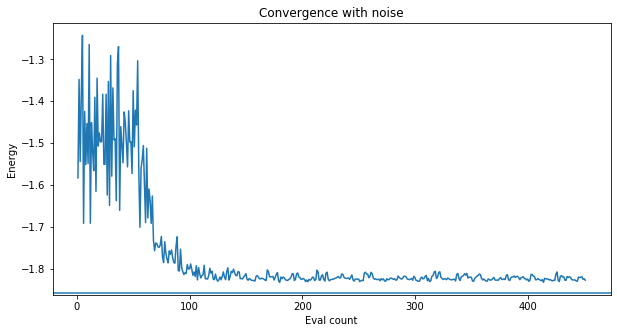

In [8]:
plt.figure(figsize=[10,5])
plt.plot(counts1, values1)
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Convergence with noise');
plt.axhline(ref)

# Lower T1 values

In [6]:
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(5e3, 1e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(7e3, 1e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['measure', 'reset', 'u2', 'cx', 'u3']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('cx', [0, 0]), ('cx', [0, 1]), ('cx', [0, 2]), ('cx', [0, 3]), ('cx', [1, 0]), ('cx', [1, 1]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 0]), ('cx', [2, 1]), ('cx', [2, 2]), ('cx', [2, 3]), ('cx', [3, 0]), ('cx', [3, 1]), ('cx', [3, 2]), ('cx', [3, 3])]


In [7]:
device = provider.get_backend('ibmq_essex')
coupling_map = device.configuration().coupling_map
noise_model = noise.device.basic_device_noise_model(device.properties())
basis_gates = noise_model.basis_gates

print(noise_model)

backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend=backend, seed_simulator=167, seed_transpiler=167,
                                   noise_model=noise_thermal)

counts = []
values = []
def store_intermediate_result1(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
    

aqua_globals.random_seed = 167
optimizer = SPSA(max_trials=200)
var_form = RY(num_qubits)
vqe = VQE(qubit_op, var_form, optimizer, callback=store_intermediate_result1)
vqe_result1 = vqe.run(quantum_instance)
print('VQE on Aer qasm simulator (with noise): {}'.format(vqe_result1['energy']))
print('Delta from reference: {}'.format(vqe_result1['energy']-ref))

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['measure', 'u2', 'cx', 'u3', 'id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('cx', [0, 1]), ('cx', [1, 0]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 1]), ('cx', [3, 1]), ('cx', [3, 4]), ('cx', [4, 3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]
VQE on Aer qasm simulator (with noise): -1.5632371207123494
Delta from reference: 0.29403790949003006


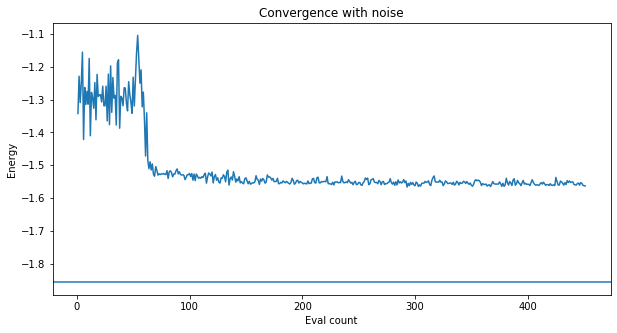

In [8]:
plt.figure(figsize=[10,5])
plt.plot(counts, values)
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Convergence with noise');
plt.axhline(ref)

In [11]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.11.1',
 'qiskit-aer': '0.3.4',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.4.5',
 'qiskit-aqua': '0.6.2',
 'qiskit': '0.14.1'}

In [10]:
import qiskit